# Introdução

**Séries temporais** são séries de dados indexadas (listadas ou visualizadas) em ordem temporal.

In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

%matplotlib inline

Como exemplo, vamos dar uma olhada em dados reais de jogos on-line. Especificamente, analisaremos os anúncios assistidos por hora e os gastos em moeda do jogo por dia

In [2]:
ads = pd.read_csv('../dataset/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('../dataset/currency.csv', index_col=['Time'], parse_dates=['Time'])

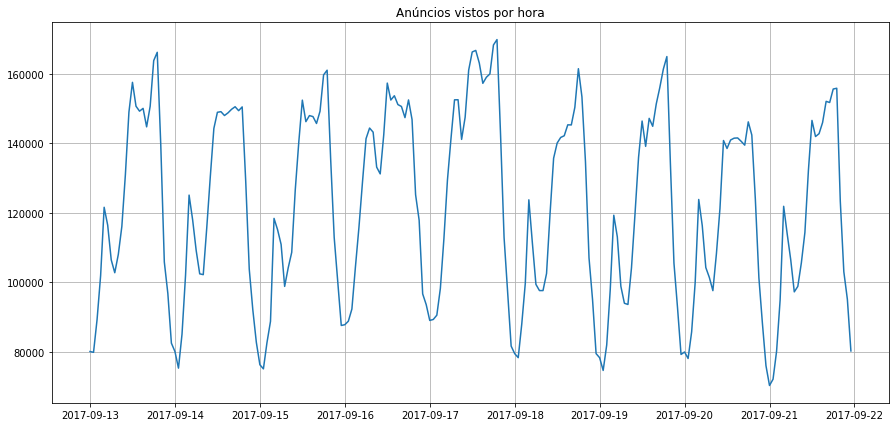

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Anúncios vistos por hora')
plt.grid(True)
plt.show()

Ao que tudo indica, esta série parece ser **estacionária**, ou seja, ela se desenvolve no tempo aleatoriamente ao redor de uma média constante, refletindo alguma forma de equilíbrio estável.

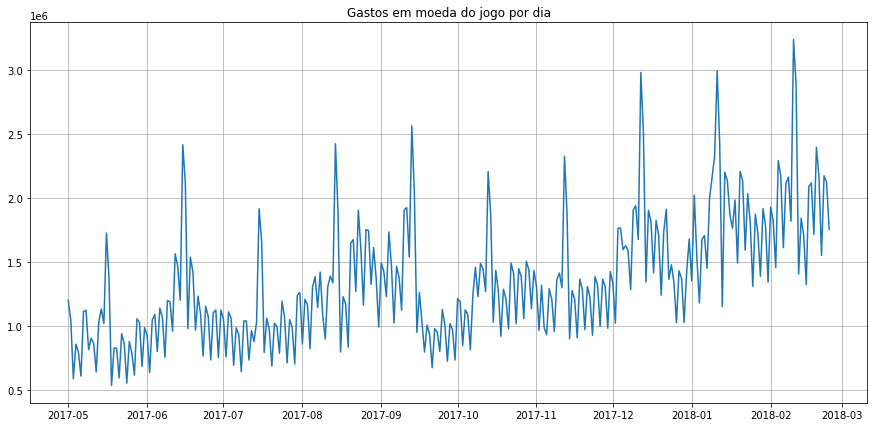

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Gastos em moeda do jogo por dia')
plt.grid(True)
plt.show()

Esta série temporal não parece ser **estacionária** visto que existe um aumento no valor médio ao final da série.

## Medidas para avaliação de modelos para séries temporais

Séries temporais são modelos de regressão , ou seja, todas as métricas aplicáveis ao modelos de regressão podem ser aplicados na avaliação de modelos de séries temporais: 

* **erro absoluto médio** $[0, +\infty)$: do ponto de vista de interpretação é a melhor escolha pois utiliza a mesma medida do valor de saída do modelo. 

$ MAE(f) = \frac{1}{n} \sum_{i=1}^{n} |y_{i} - f(\vec x_{i})| $

````python
sklearn.metrics.mean_absolute_error
````

* **erro quadrado médio** $[0, +\infty)$: é uma medida que valoriza os erros extremos, mesmo ocorrendo com pouca frequência. Por exemplo, se para o problema que está sendo analisado errar por 10 é pior que errar duas vezes por 5 então a melhor escolha é $MSE$. Caso contrário, se errar por 10 é igual que errar duas vezes por 5 então a melhor escolha é $MAE$. 

$MSE(f) = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - f(\vec x_{i}))^{2} $

````python
sklearn.metrics.mean_squared_error
````

* **R squared** ou **coeficiente de determinação** $[0, 1]$: coeficiente de determinação. Em econometria, isto pode ser interpretado como o percentual de variância explicado pelo modelo. Ou seja, quanto mais próximo de 1, melhor.

$SQ_{tot} = \sum_{i=1}^{n} (y_{i} - \bar{y})^{2}$, onde $\bar{y}$ é o valor médio para $y$.

$SQ_{res} = \sum_{i=1}^{n} (y_{i} - f(\vec x_{i}))^{2}$, onde $f(\vec x_{i})$ é o valor predito para $y_{i}$.

$R^{2} = 1 - \frac{SQ_{res}}{SQ_{tot}}$

````python
sklearn.metrics.r2_score
````


## Média móvel

Vamos começar com uma hipótese ingênua: "amanhã vai ser igual a hoje". No entanto, ao invés de fazer $ \hat{y_{t}} = y_{t-1}$, vamos assumir que o valor futuro depende da média de $k$ valores anteriores. Desta forma, vamos usar uma **média móvel**:   

$ \hat{y_{t}} = \frac{1}{k} \sum_{n=1}^{k} y_{t-n}$

In [5]:
def moving_average(series, n):
    """
        Calcula a media considerando as N ultimas observacoes
    """
    return np.average(series[-n:])

moving_average(ads, 24) # preve o proximo valor considerando as ultimas 24 horas

116805.0

In [6]:
from sklearn.metrics import mean_absolute_error

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Vamos aplicar a média móvel com diversas janelas

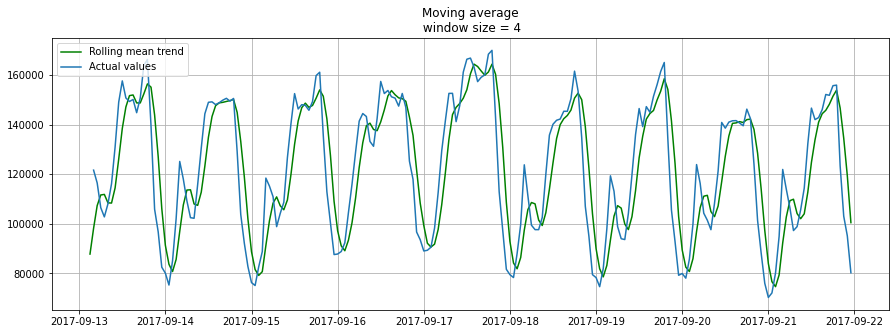

In [7]:
plotMovingAverage(ads, 4) 

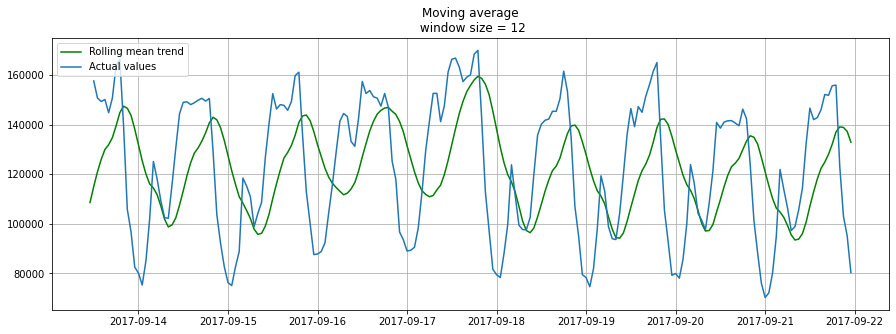

In [8]:
plotMovingAverage(ads, 12) 

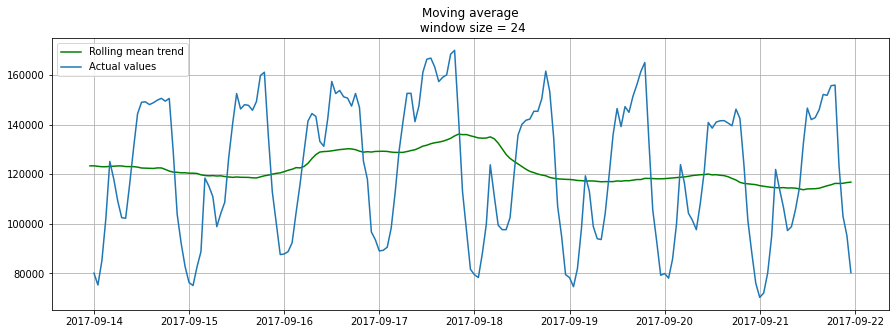

In [9]:
plotMovingAverage(ads, 24) 

Também podemos imprimir intervalos de confiança:

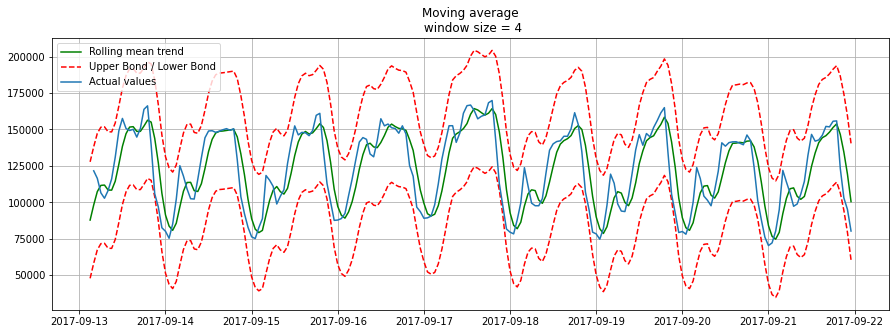

In [10]:
plotMovingAverage(ads, 4, plot_intervals=True)

Será que tem alguma anomalia nesta série temporal? 

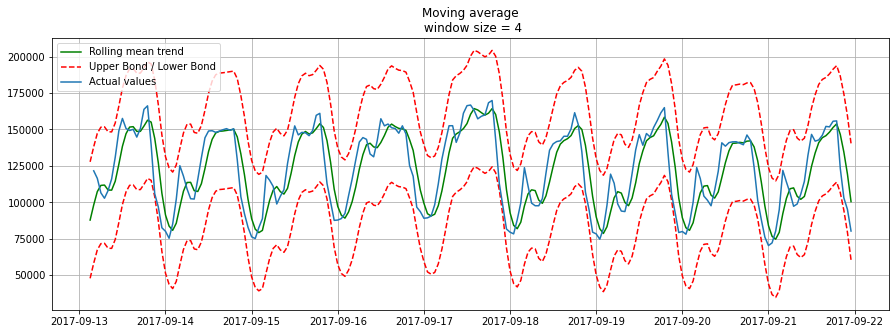

In [11]:
plotMovingAverage(ads, 4, plot_intervals=True, plot_anomalies=True)

E para a outra série temporal? 

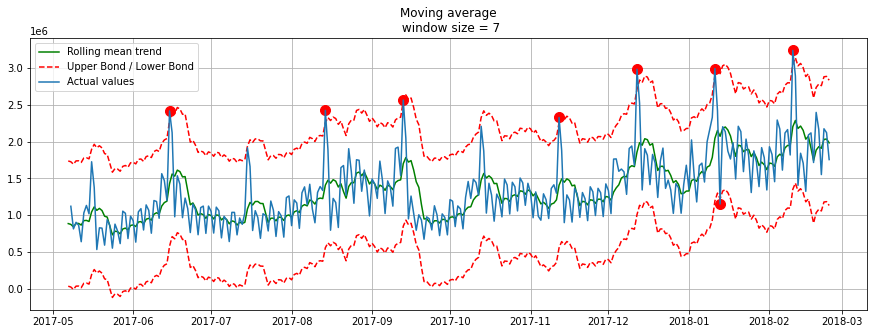

In [12]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

Talvez, o conceito de média móvel simples não funcione muito bem para esta série temporal. Existem outras formas de cálculo de média móvel, entre elas **média móvel ponderada** onde fornecemos pesos aos valores da série histórica que precisam ser considerados:

$ \hat{y_{t}} = \frac{1}{k} \sum_{n=1}^{k} \omega_{n} \times y_{t-n}$


In [13]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

Considerando uma janela com tamanho 3, onde o primeiro elemento tem peso 0.6 e o ultimo tem peso 0.1:

In [14]:
weighted_average(ads, [0.6, 0.3, 0.1])

87025.5

entre outras. Mas, não vamos entrar em detalhes sobre como médias móveis podem ser ajustadas.

## Cross-validation para séries temporais

Em uma série temporal, diferente de selecionar aleatóriamente os exemplos para treino e teste, é necessário selecionar os conjuntos de treinamento e teste respeitando a relação temporal como ilustrado na figura abaixo:

![Cross-validation](../references/timeSeriesCV.png "Cross-validation para séries temporais")

A classe `sklearn.model_selectionTimeSeriesSplit` pode ser usada para implementar cross-validation para séries temporais.

## Regressão Linear em séries temporais

Podemos utilizar regressão linear para estimar os valores de uma série temporal. Principalmente, quando temos variáveis independentes que podem ser utilizadas como entrada do modelo. Por exemplo, quando temos o dia da semana ou a hora do dia para determinar a quantidade de acessos ao site naquele momento. 

Variáveis que podem ser extraídas de uma séria temporal são: 

* lags da variável de interesse. Ou seja, utilizamos $y_{-1}, y_{-2}, \cdots, y_{-N}$ como variáveis de entrada do modelo;

* a hora daquele evento;

* o dia da semana daquele evento; 

* o mês daquele evento;

* o dia do mês daquele evento. 

### Lag de séries temporais

In [15]:
# criando uma copia do dataframe para aplicar diversas transformacoes
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

In [16]:
# adicionando um lag da variavel objetivo considerando uma janela de 6 até 25
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [17]:
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 17:00:00,151790,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0
2017-09-21 18:00:00,155665,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


In [18]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [19]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# 30% eh mantido para teste
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [20]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error 

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        tscv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error: {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

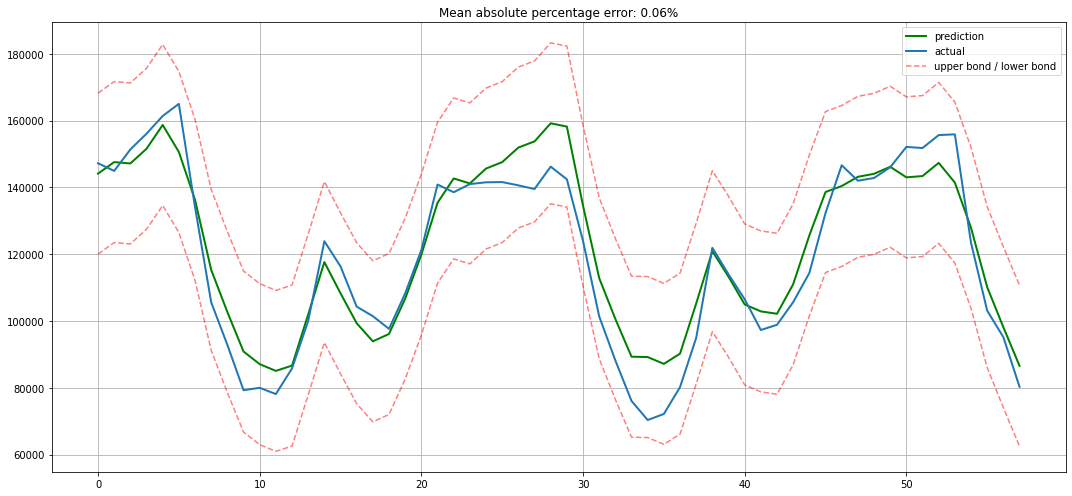

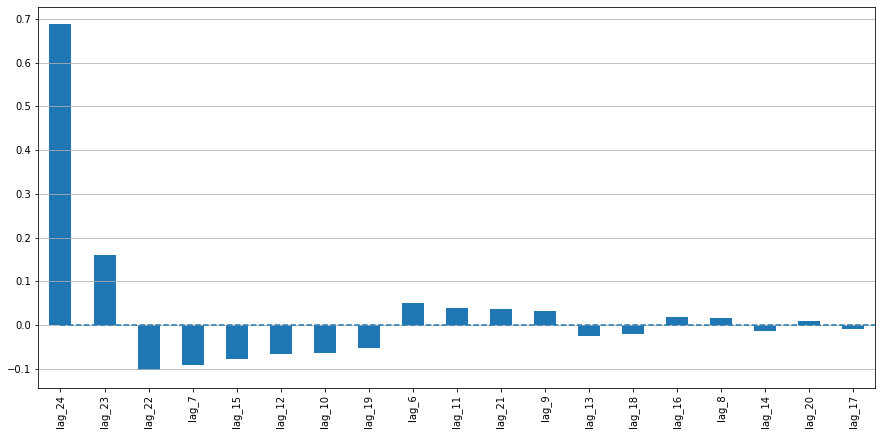

In [22]:
plotModelResults(lr, X_train=X_train, X_test=X_test, plot_intervals=True)
plotCoefficients(lr)

### Novos atributos e scaling das variáveis

A partir da data podemos criar novos atributos: 

In [23]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


Neste momento temos inúmeras variáveis com escalas diferentes. Neste caso, é adequado transformar todos os atributos na mesma escala porque assim fica mais fácil explorar a importância que cada atributo tem no modelo e também implementar algum tipo de *regularization*. 

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

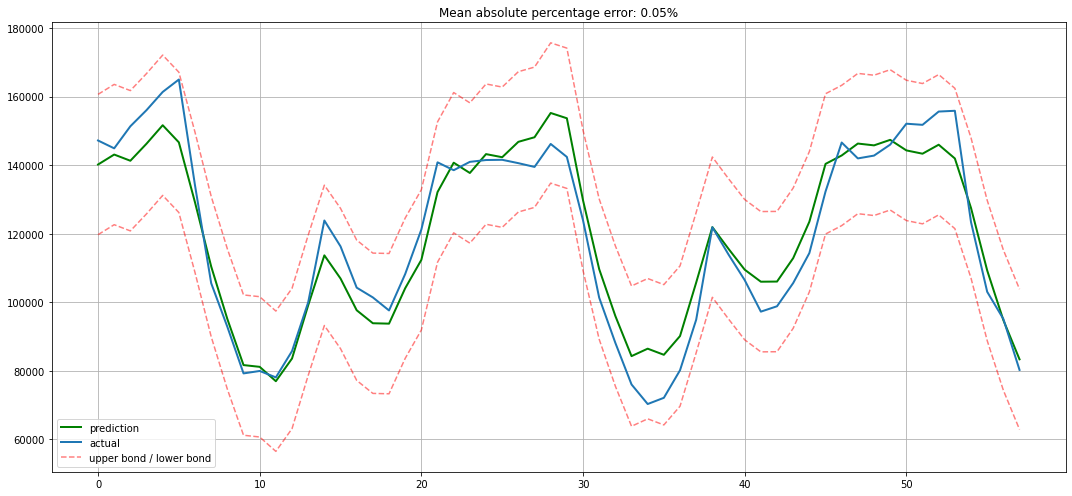

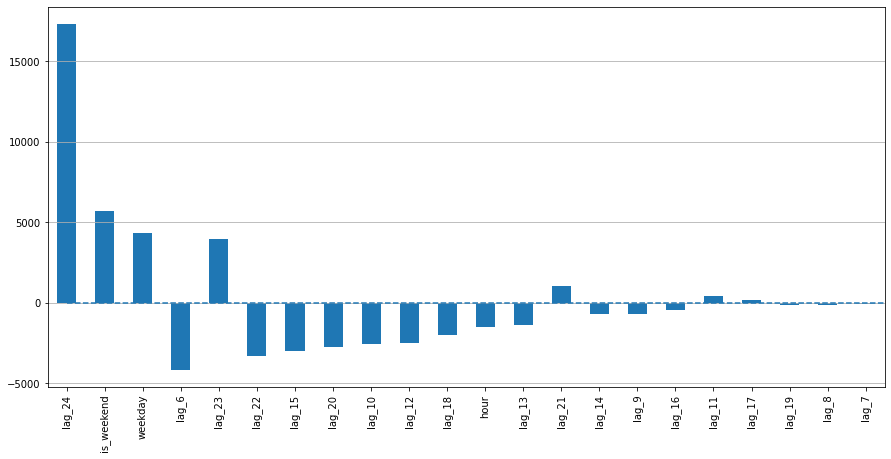

In [25]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

### Regularization: Ridge e Lasso

Este [vídeo](https://www.youtube.com/watch?v=Q81RR3yKn30) fornece uma explicação muito simples de como o algoritmo Ridge funciona e como funciona o conceito de regularização de modelos lineares.

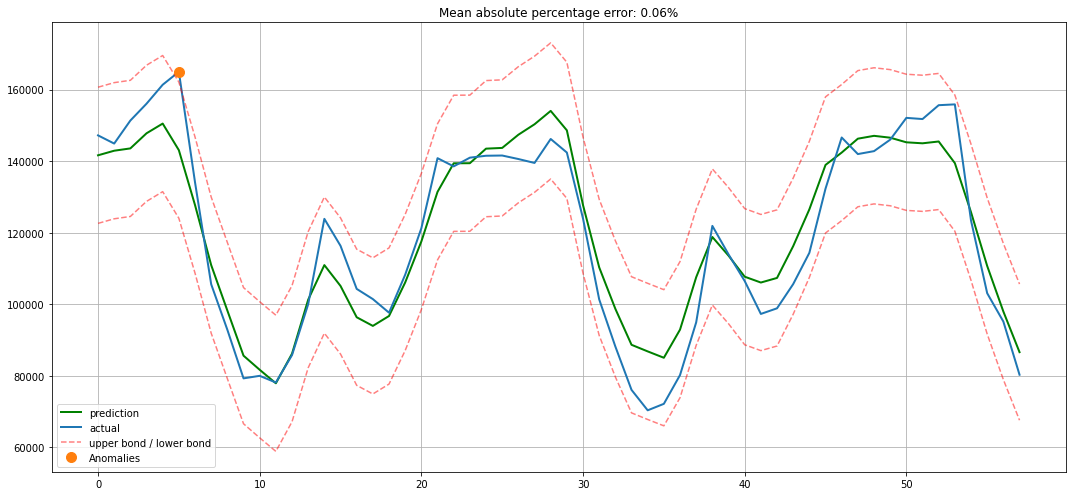

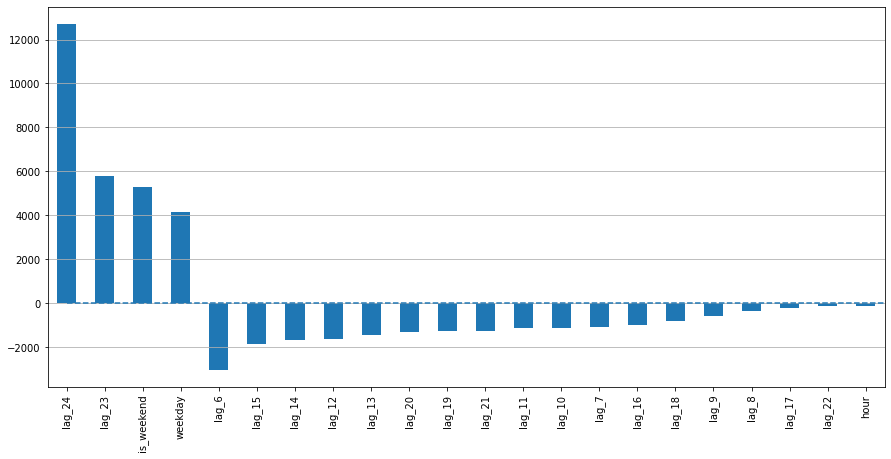

In [26]:
from sklearn.linear_model import LassoCV, RidgeCV

tscv = TimeSeriesSplit(n_splits=5)
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

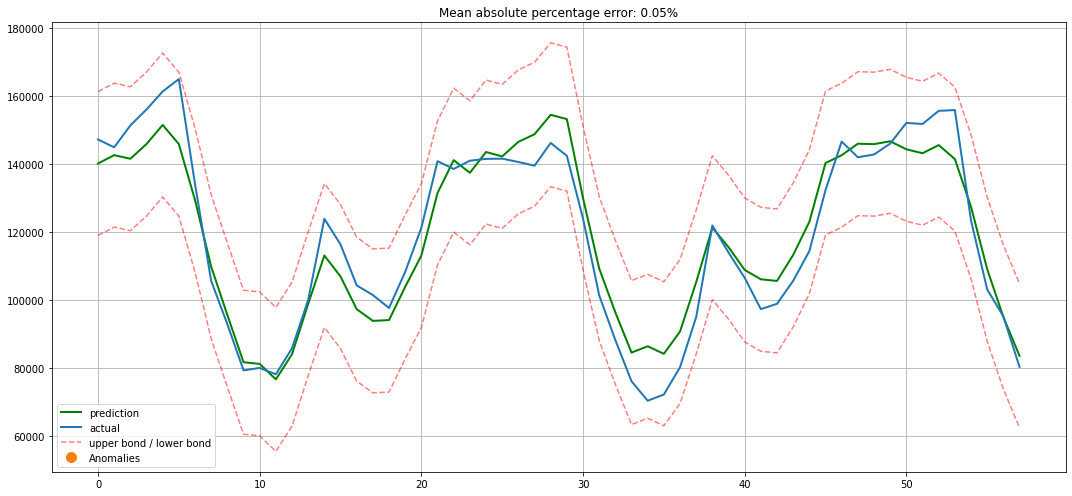

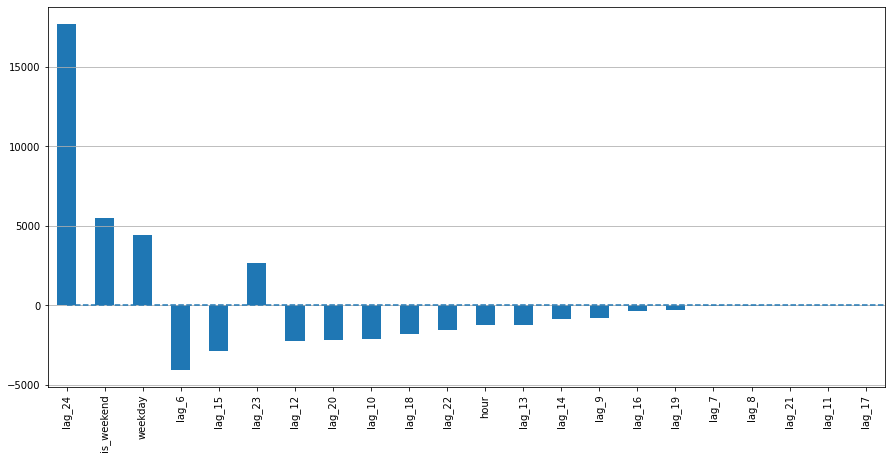

In [27]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

## Boosting

In [28]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

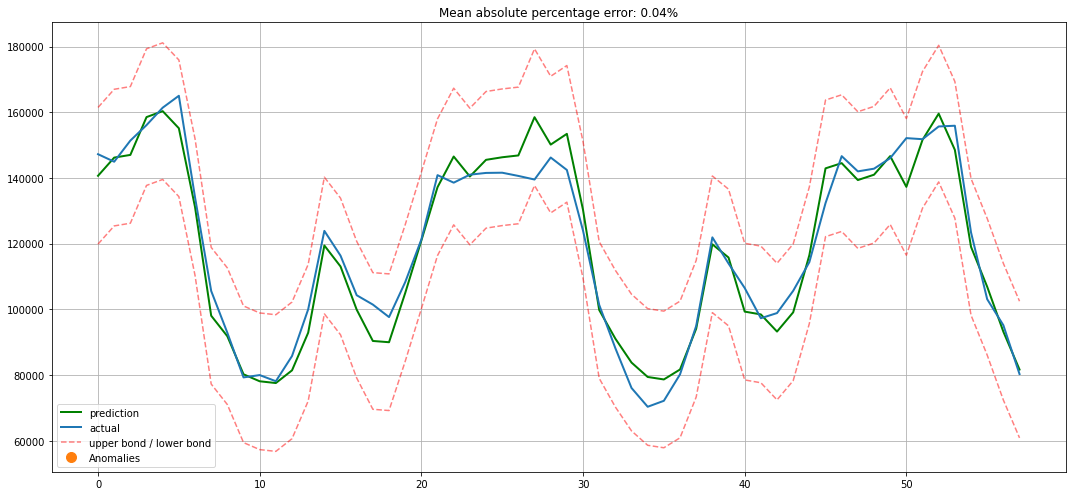

In [29]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)